<a href="https://colab.research.google.com/github/Joovvhan/korean-stt/blob/master/notebooks/NSML_eumun_to_eumjul_network.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
import torch
import torch.nn as nn
from torch import optim
import torch.nn.functional as F

import numpy as np
import copy
import matplotlib.pyplot as plt
import random

from tqdm import tqdm_notebook as tqdm
from datetime import datetime

In [17]:
from google.colab import drive
drive.mount('/content/gdrive', force_remount=True)

Mounted at /content/gdrive


In [0]:
data_path = 'gdrive/My Drive/korean-single-speaker-speech-dataset/eumjul_eumun_pairs.npy'

pairs = np.load(data_path)

In [19]:
unicode_jamo_list = list()
for unicode in range(0x1100, 0x1113):
    unicode_jamo_list.append(chr(unicode))
    
for unicode in range(0x1161, 0x1176):
    unicode_jamo_list.append(chr(unicode))
    
for unicode in range(0x11A8, 0x11C3):
    unicode_jamo_list.append(chr(unicode))
    
unicode_jamo_list += [' ', '!', ',', '.', '?', '<sos>', '<eos>']
# unicode_jamo_list += [' ', '!', ',', '.', '?', '<eos>']
    
unicode_jamo_list.sort()

# unicode_jamo_list = ['-'] + unicode_jamo_list

print(unicode_jamo_list)
print(len(unicode_jamo_list))

[' ', '!', ',', '.', '<eos>', '<sos>', '?', 'ᄀ', 'ᄁ', 'ᄂ', 'ᄃ', 'ᄄ', 'ᄅ', 'ᄆ', 'ᄇ', 'ᄈ', 'ᄉ', 'ᄊ', 'ᄋ', 'ᄌ', 'ᄍ', 'ᄎ', 'ᄏ', 'ᄐ', 'ᄑ', 'ᄒ', 'ᅡ', 'ᅢ', 'ᅣ', 'ᅤ', 'ᅥ', 'ᅦ', 'ᅧ', 'ᅨ', 'ᅩ', 'ᅪ', 'ᅫ', 'ᅬ', 'ᅭ', 'ᅮ', 'ᅯ', 'ᅰ', 'ᅱ', 'ᅲ', 'ᅳ', 'ᅴ', 'ᅵ', 'ᆨ', 'ᆩ', 'ᆪ', 'ᆫ', 'ᆬ', 'ᆭ', 'ᆮ', 'ᆯ', 'ᆰ', 'ᆱ', 'ᆲ', 'ᆳ', 'ᆴ', 'ᆵ', 'ᆶ', 'ᆷ', 'ᆸ', 'ᆹ', 'ᆺ', 'ᆻ', 'ᆼ', 'ᆽ', 'ᆾ', 'ᆿ', 'ᇀ', 'ᇁ', 'ᇂ']
74


In [0]:
class Tokenizer():
    def __init__(self, vocabs):
        self.vocabs = vocabs
        
    def word2num(self, sentence):
        tokens = list()
        for char in sentence:
            tokens.append(self.vocabs.index(char))    
        return tokens
        
    def word2vec(self, sentence):
        vectors = np.zeros((len(sentence), len(self.vocabs)))
        for i, char in enumerate(sentence):
            vectors[i, self.vocabs.index(char)] = 1   
        return vectors
    
    def num2word(self, num):
        output = list()
        for i in num:
            output.append(self.vocabs[i])
        return output
    
    def num2vec(self, numbers):
        vectors = np.zeros((len(numbers), len(self.vocabs)))
        for i, num in enumerate(numbers):
            vectors[i, num] = 1   
        return vectors

In [0]:
tokenizer = Tokenizer(unicode_jamo_list)
jamo_tokens = tokenizer.word2num(unicode_jamo_list)

tokenized_pair = [[tokenizer.word2num(list(pairs[i, 0]) + ['<eos>']), tokenizer.word2num(list(pairs[i, 1]) + ['<eos>'])] for i in range(len(pairs))]

In [22]:
idxs = range(0, len(tokenized_pair))

train_size = int(0.8 * len(tokenized_pair))

train_idxs = set(np.random.choice(idxs, train_size, False))

total_idxs_set = set(idxs)

eval_idxs = list(total_idxs_set - train_idxs)

train_idxs = list(train_idxs)

train_pairs = [tokenized_pair[idx] for idx in train_idxs]
eval_pairs = [tokenized_pair[idx] for idx in eval_idxs]

print("Size of the total pairs: {}".format(len(tokenized_pair)))
print("Size of the training pairs: {}".format(len(train_pairs)))
print("Size of the evaluation pairs: {}".format(len(eval_pairs)))

Size of the total pairs: 51955
Size of the training pairs: 41564
Size of the evaluation pairs: 10391


In [0]:
def ordered_shuffling(pairs, shuffle_step = 12):
    eumun_length_list = np.asarray([len(pair[1]) for pair in pairs])
    
#   print(eumun_length_list)
    
    sorted_order = np.argsort(eumun_length_list)
    
    bundle = np.stack([eumun_length_list[sorted_order], sorted_order])

    for seq_len in range(shuffle_step, np.max(eumun_length_list), shuffle_step):
        idxs = np.where((bundle[0, :] > seq_len) & (bundle[0, :] <= seq_len + shuffle_step))[0]
        idxs_origin = copy.deepcopy(idxs)
        random.shuffle(idxs)
        bundle[:, idxs_origin] = bundle[:, idxs]

    shuffled_sorted_order = bundle[1, :]
    
#     plt.figure()
#     plt.plot(eumun_length_list[shuffled_sorted_order])
#     plt.show()
    
    return [pairs[order] for order in shuffled_sorted_order]

In [24]:
len(ordered_shuffling(train_pairs))

41564

In [0]:
class Batch_Loader():
    def __init__(self, sentence_pairs, shuffle_step = 12, batch_size = 1000):
        super(Batch_Loader).__init__()
        self.sentence_pairs = sentence_pairs
        self.total_num_input = len(sentence_pairs)
        self.shuffle_step = shuffle_step
        self.end_flag = True
        self.batch_size = batch_size
        self.current_loading_index = 0
    
    def initialize_batch(self):
        self.sentence_pairs = ordered_shuffling(self.sentence_pairs)
        self.current_loading_index = 0
        self.end_flag = False
        
        return
    
    def get_batch(self):
        
        eumjul_list = list()
        eumun_list = list()
        eumjul_length_list = list()
        eumun_length_list = list()

        count = 0
        max_eumjul_len = 0
        max_eumun_len = 0
        
        for i in range(self.batch_size):
            
            if self.current_loading_index >= self.total_num_input:
                self.end_flag = True
                break
            
            pair = self.sentence_pairs[self.current_loading_index]
            eumjul = pair[0]
            eumun = pair[1]
            
            eumjul_list.append(eumjul)
            eumun_list.append(eumun)
            
            eumjul_length_list.append(len(eumjul))
            eumun_length_list.append(len(eumun))
            
            if (len(eumjul) > max_eumjul_len):
                max_eumjul_len = len(eumjul)
            if (len(eumun) > max_eumun_len):
                max_eumun_len = len(eumun)  
            
            self.current_loading_index += 1
            count += 1
            
        batched_eumjul = torch.zeros(count, max_eumjul_len)
        batched_eumun = torch.zeros(count, max_eumun_len)
        batched_loss_mask = torch.zeros(count, max_eumjul_len)
        
#         print(eumjul_list)
        
        for order in range(count):
        
            batched_eumjul[order, :eumjul_length_list[order]] = torch.tensor(eumjul_list[order])
            batched_eumun[order, :eumun_length_list[order]] = torch.tensor(eumun_list[order])
            batched_loss_mask[order, :eumjul_length_list[order]] = torch.ones(eumjul_length_list[order])
        
        return batched_eumjul, batched_eumun, batched_loss_mask

In [0]:
# eumjul_batch, eumun_batch, eumun_loss_mask = train_batch_loader.get_batch()

In [0]:
# https://pytorch.org/tutorials/intermediate/seq2seq_translation_tutorial.html
############################################################################

class EncoderRNN(nn.Module):
    def __init__(self, hidden_size):
        super(EncoderRNN, self).__init__()
        self.hidden_size = hidden_size
#         self.gru = nn.GRU(hidden_size, hidden_size)
        self.gru = nn.GRU(hidden_size, int(hidden_size/2), bidirectional=True)

    def forward(self, input, hidden):
        output, hidden = self.gru(input, hidden)
        
        return output, hidden

    def initHidden(self, batch_size):
#         return torch.zeros(1, batch_size, self.hidden_size, device=device)
          return torch.zeros(2, batch_size, int(self.hidden_size/2), device=device)
    
class AttnDecoderRNN(nn.Module):
    def __init__(self, hidden_size, output_size, dropout_p=0.1, max_length=10):
        super(AttnDecoderRNN, self).__init__()
        self.hidden_size = hidden_size
        self.output_size = output_size
        self.dropout_p = dropout_p
        self.max_length = max_length

        self.attn = nn.Linear(self.hidden_size * 2, self.hidden_size)
        self.attn_combine = nn.Linear(self.hidden_size * 2, self.hidden_size)
        self.dropout = nn.Dropout(self.dropout_p)
        self.gru = nn.GRU(self.hidden_size, self.hidden_size)
        self.out = nn.Linear(self.hidden_size, len(jamo_tokens))

    def forward(self, embedded, hidden, encoder_outputs):

        embedded = self.dropout(embedded)
        
#         print(embedded.shape)
#         print(hidden.shape)
        
        #(1, B, H) + (1, B, H) = (1, B, 2H)        
        concated_tensor = torch.cat((embedded, hidden), 2)
        
        # (1, B, H)
        key = self.attn(concated_tensor)
        
        # (B, H, 1)
        key = key.permute(1, 2, 0)
        
        # (B, L, 1)        
        attention_value = torch.bmm(encoder_outputs, key)
        
        attn_weights = F.softmax(attention_value, dim=1)
        
        # (B, 1, L)
        attn_weights = attn_weights.permute(0, 2, 1)
        
        # (B, 1, H)
        attn_applied = torch.bmm(attn_weights, encoder_outputs)

        # (1, B, H)
        attn_applied = attn_applied.permute(1, 0, 2)
        
        # (1, B, 2H)
        output = torch.cat((embedded, attn_applied), 2)
        
        # (1, B, H)
        output = self.attn_combine(output)

        output = F.relu(output)
        
        # (1, B, H)
        output, hidden = self.gru(output, hidden)

        # (1, B, 74)
        output = F.log_softmax(self.out(output), dim=2)
        return output.squeeze(0), hidden, attn_weights.squeeze(1)

    def initHidden(self):
        return torch.zeros(1, 1, self.hidden_size, device=device)
    
    
class Seq2SeqNet():
    def __init__(self, hidden_size):
        super(Seq2SeqNet, self).__init__()
        
        device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
        
        self.device = device
        
        self.hidden_size = hidden_size
        
        self.embedding_layer = nn.Embedding(len(jamo_tokens), hidden_size).to(device) 
        self.embedding_layer_2 = nn.Embedding(len(jamo_tokens), hidden_size).to(device)
        self.encoder = EncoderRNN(hidden_size).to(device)
        self.decoder = AttnDecoderRNN(hidden_size,len(jamo_tokens), dropout_p=0.1).to(device)
        
        self.embedding_optimizer = optim.SGD(self.embedding_layer.parameters(), lr=0.001)  
        self.embedding_optimizer_2 = optim.SGD(self.embedding_layer_2.parameters(), lr=0.001)  
        self.encoder_optimizer = optim.Adam(self.encoder.parameters(), lr=0.001)
        self.decoder_optimizer = optim.Adam(self.decoder.parameters(), lr=0.001)

#         self.criterion = nn.CrossEntropyLoss(reduction='none').to(device)
        self.criterion = nn.NLLLoss(reduction='none').to(device)
#         self.ctc_loss = nn.CTCLoss().to(device)
        
        for param in self.encoder.parameters():
            param.data.uniform_(-0.1, 0.1)
        for param in self.embedding_layer.parameters():
            param.data.uniform_(-0.1, 0.1)
        for param in self.embedding_layer_2.parameters():
            param.data.uniform_(-0.1, 0.1)
        for param in self.decoder.parameters():
            param.data.uniform_(-0.1, 0.1)
            
    def train(self, input_tensor, target_tensor, loss_mask):
        
        self.embedding_optimizer.zero_grad()
        self.embedding_optimizer_2.zero_grad()
        self.encoder_optimizer.zero_grad()
        self.decoder_optimizer.zero_grad()

        batch_size = input_tensor.shape[0]
        input_length = input_tensor.shape[1]
        target_length = target_tensor.shape[1]
        
#       input_tensor = torch.cuda.LongTensor(input_tensor.long().to(device))
        input_tensor = torch.cuda.LongTensor(input_tensor.long())
        target_tensor = torch.cuda.LongTensor(target_tensor.long())
        
        embedded_tensor = self.embedding_layer(input_tensor)
        
        embedded_tensor = embedded_tensor.permute(1, 0, 2)
        
        # (L, B)
        target_tensor = target_tensor.permute(1, 0)

        encoder_outputs = torch.zeros(input_length, batch_size, self.hidden_size, device=self.device)

        loss = 0

        encoder_hidden = self.encoder.initHidden(batch_size)

        for ei in range(input_length):
            embedded_slice = embedded_tensor[ei].unsqueeze(0)
            encoder_output, encoder_hidden = self.encoder(
                embedded_slice, encoder_hidden)
            encoder_outputs[ei] = encoder_output
            
        decoder_input_token = torch.tensor(tokenizer.word2num(['<sos>'] * batch_size)).long().unsqueeze(0).to(device)

        
        # Override encoder hidden state
        encoder_hidden = encoder_outputs[-1, :, :].unsqueeze(0)
        
        # (L, B, H) -> (B, L, H)
        encoder_outputs = encoder_outputs.permute(1, 0, 2)

        # Override encoder_hidden
        
        decoder_hidden = encoder_hidden
        
        decoder_attentions = torch.zeros([batch_size, input_length, target_length])
        decoder_outputs = torch.zeros([batch_size, target_length, len(jamo_tokens)])

        for di in range(target_length):
            decoder_input = self.embedding_layer_2(decoder_input_token)
            
            decoder_output, decoder_hidden, decoder_attention = self.decoder(
                decoder_input, decoder_hidden, encoder_outputs)

            loss += torch.mean(self.criterion(decoder_output, target_tensor[di]) * loss_mask[:, di])

            if np.random.rand() < 0.8:        
                decoder_input_token = target_tensor[di].unsqueeze(0)
            else:
                decoder_input_token = torch.argmax(decoder_output, dim=1).unsqueeze(0)
            
            decoder_attentions[:, :, di] = decoder_attention
            decoder_outputs[:, di, :] = decoder_output
            
#       print(decoder_output.shape)

        loss.backward()

        self.embedding_optimizer.step()
        self.embedding_optimizer_2.step()
        self.encoder_optimizer.step()
        self.decoder_optimizer.step()

        return decoder_outputs, decoder_attentions, loss.item() / target_length
    
    

    def evaluate(self, input_tensor, target_tensor, loss_mask):
        
        batch_size = input_tensor.shape[0]
        input_length = input_tensor.shape[1]
        target_length = target_tensor.shape[1]
        
        input_tensor = torch.cuda.LongTensor(input_tensor.long())
        target_tensor = torch.cuda.LongTensor(target_tensor.long())
        
        embedded_tensor = self.embedding_layer(input_tensor)
        embedded_tensor = embedded_tensor.permute(1, 0, 2)
        
        # (L, B)
        target_tensor = target_tensor.permute(1, 0)

        encoder_outputs = torch.zeros(input_length, batch_size, self.hidden_size, device=self.device)

        loss = 0

        encoder_hidden = self.encoder.initHidden(batch_size)

        for ei in range(input_length):
            embedded_slice = embedded_tensor[ei].unsqueeze(0)
            encoder_output, encoder_hidden = self.encoder(
                embedded_slice, encoder_hidden)
            encoder_outputs[ei] = encoder_output
            
        decoder_input_token = torch.tensor(tokenizer.word2num(['<sos>'] * batch_size)).long().unsqueeze(0).to(device)

        # Override encoder hidden state
        encoder_hidden = encoder_outputs[-1, :, :].unsqueeze(0)
        
        # (L, B, H) -> (B, L, H)
        encoder_outputs = encoder_outputs.permute(1, 0, 2)

        decoder_hidden = encoder_hidden
        
        decoder_attentions = torch.zeros([batch_size, input_length, target_length])
        decoder_outputs = torch.zeros([batch_size, target_length, len(jamo_tokens)])

        for di in range(target_length):
            decoder_input = self.embedding_layer_2(decoder_input_token)

            decoder_output, decoder_hidden, decoder_attention = self.decoder(
                decoder_input, decoder_hidden, encoder_outputs)
            loss += torch.mean(self.criterion(decoder_output, target_tensor[di]) * loss_mask[:, di])
                        
            # decoder_input_token = target_tensor[di].unsqueeze(0)
            decoder_input_token = torch.argmax(decoder_output, dim=1).unsqueeze(0)
            
            decoder_attentions[:, :, di] = decoder_attention
            decoder_outputs[:, di, :] = decoder_output


        return decoder_outputs, decoder_attentions, loss.item() / target_length
    
    def save(self, check_point_name):
        torch.save({
            'embedding_layer_state_dict': self.embedding_layer.state_dict(),
            'embedding_layer_2_state_dict': self.embedding_layer_2.state_dict(),
            'encoder_state_dict': self.encoder.state_dict(),
            'decoder_state_dict': self.decoder.state_dict(),
            'embedding_optimizer_state_dict': self.embedding_optimizer.state_dict(),
            'embedding_optimizer_2_state_dict': self.embedding_optimizer_2.state_dict(),
            'encoder_optimizer_state_dict': self.encoder_optimizer.state_dict(),
            'decoder_optimizer_state_dict': self.decoder_optimizer.state_dict(),
            }, check_point_name)
    
    def load(self, check_point_name):
        checkpoint = torch.load(check_point_name)
        self.embedding_layer.load_state_dict(checkpoint['embedding_layer_state_dict'])
        self.embedding_layer_2.load_state_dict(checkpoint['embedding_layer_2_state_dict'])
        self.encoder.load_state_dict(checkpoint['encoder_state_dict'])
        self.decoder.load_state_dict(checkpoint['decoder_state_dict'])
        self.embedding_optimizer.load_state_dict(checkpoint['embedding_optimizer_state_dict'])
        self.embedding_optimizer_2.load_state_dict(checkpoint['embedding_optimizer_2_state_dict'])
        self.encoder_optimizer.load_state_dict(checkpoint['encoder_optimizer_state_dict'])
        self.decoder_optimizer.load_state_dict(checkpoint['decoder_optimizer_state_dict'])
        
    def set_mode(self, mode):
        
        if mode == 'train':
            self.embedding_layer.train()
            self.embedding_layer_2.train()
            self.encoder.train()
            self.decoder.train()
            
        elif mode == 'eval':
            self.embedding_layer.eval()
            self.embedding_layer_2.eval()
            self.encoder.eval()
            self.decoder.eval()
            
        else:
            print("Invalid mode string: {}".format(mode))
    
net = Seq2SeqNet(256)

In [38]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")      
print(device)

cuda:0


In [0]:
train_batch_loader = Batch_Loader(train_pairs, 12, 1024)
train_batch_loader.initialize_batch()

eval_batch_loader = Batch_Loader(eval_pairs, 12, 1024)
eval_batch_loader.initialize_batch()

09-21 16:30:23
09-21 16:31:23
Mean Train Loss: 2.274192422714752
09-21 16:31:28
Mean Evaluation Loss: 3.266784739736337


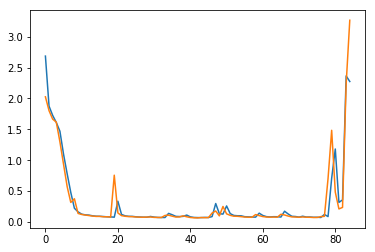

중구게서도 조선 시대 한구게 화약 쩨조와 화기에 군사적 화룡에 대해 노피 평까해쓰며 그 시기 일보는 우리이 기수를 배우기 위하여 애썯따.<eos>                                                                                                                                                  
진으 은 ᆼᅳ 웅ᅳᆨ 운ᅳ 잉 ᅳ 으 이 ᅳᆫ 아 ᅵ ᅳ 앙ᅳ ᅳ 안 ᅡᆫᅵᆨ으ᅡᆫ 여이 이 ᅡ 앙으 운앙ᄋ 은ᅧᅩᆼ알이 ᅡ 이 이  ᅳᆫ 이 ᅳ으 이 ᅮᆫ ᅳᆫ 우 ᅵ 우인ᅡᆫᅵ 이 ᅳᆼ으ᄋ<eos>이 ᄋᄋᄋᄋᄋᄋᄋ이ᄋ이ᄋᄋᄋᄋ이 ᄋᄋ이ᄋᄋ이 ᄋᄋᄋᄋ이ᄋ이ᄌᄋᄋ이 ᄋᄋᄋᄋᄋᄋᄋᄋᄋᄋᄋᄋᄋᄋᄋᄋᄋᄋᄋᄋ이ᄋ이ᄋᄋᄋ이 ᄋᄋ이ᄋᄋᄋᄋᄋᄋ이ᄋ이ᄋᄋᄋᄋ이ᄋ이ᄋᄋ이 ᄋᄋᄋ이ᄋᄋᄋᄋᄋ이ᄋᄋᄋᄋ이ᄋᄋᄋᄋᄋᄋᄋ이ᄋ이 ᄋᄋᄋᄋᄋᄋ이
중국에서도 조선 시대 한국의 화약 제조와 화기의 군사적 활용에 대해 높이 평가했으며, 그 시기 일본은 우리의 기술을 배우기 위하여 애썼다.<eos>                                                                                                                                                 
구청장은 국까 믿 시장이 수리판 기후변화 저긍대책 꼐회게 따라 구에 지역씰쩡에 저카판 

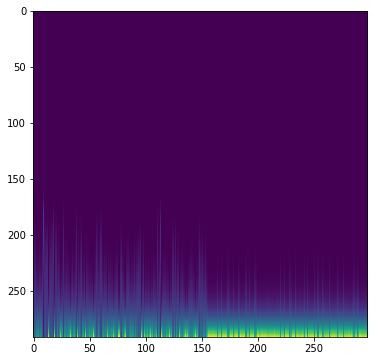

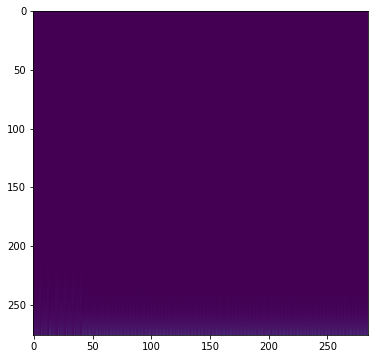

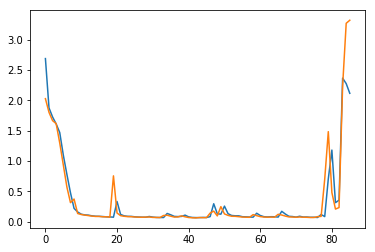

이와 가튼 차워네서 최근 서울 등에 대도시에는 도심부에 나마인는 오래된 단독쭈택찌에 대한 개선 방안드리 활발하게 진행되고 읻따.<eos>                                                                                                                                                
간 ᄋ은은 인ᅳᆫ ᅳᆫᅳᆼ안 ᆫ 웅ᅳᆫ 안으 아 ᄋᆼᅡᆫᅳ ᄋᆫ 아 이 ᅡᆫᅳ 안응은ᅳᆫ 안ᅳᆫᅡᄋ 안 ᅡᆼ엉ᅡ 어 ᅳ 아 ᅡᆫ 이 ᅥᆼ 안잉 ᅡᆫ ᅳ 아ᄋ ᅡᆫ ᅡᆫᅡ 앙으 아아 아 안<eos>ᄋᄋᄋᄋᄋᄋᄋᄋᄋ아ᄋᄋᄋᄋᄋᄋᄋᄋ아이ᄋ아ᄋᄋᄋ이이ᄋᄋᄋᄋᄋᄋᄋᄋᄋᄋᄋᄋᄋᄋᄋᄋᄋᄋ안앙ᄋᄋᄋᄋᄋᄋᄋ이 이이ᄋᄋᄋᄋᄋᄋᄋᄋᄋᄋᄋᄋᄋᄋᄋᄋᄋᄋᄋᄋᄋᄋᄋᄋᄋᄋ이ᄋᄋ이ᄋᄋᄋᄋᄋᄋᄋ이이 ᄋ이이이ᄋᄋ이 ᄋᄋᄋᄋᄋᄋ아ᄋᄋᄋᄋᄋᄋᄋ이ᄋ아
이와 같은 차원에서 최근 서울 등의 대도시에는 도심부에 남아있는 오래된 단독주택지에 대한 개선 방안들이 활발하게 진행되고 있다.<eos>                                                                                                                                                   
스위스과는 거꾸로 된 신바를 시는 블루칼라 남자드레 퍼포먼스 영상을 통해 거꾸로 거르므

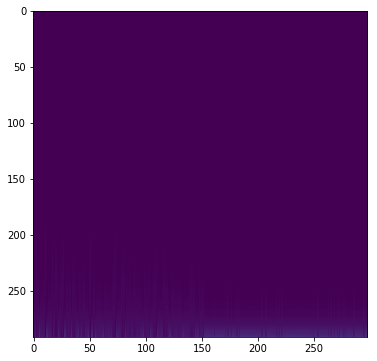

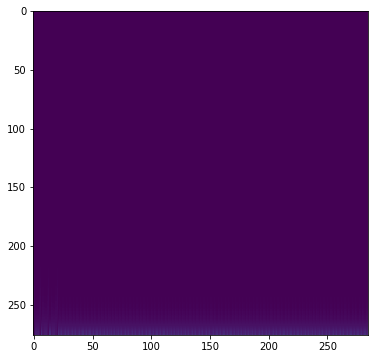

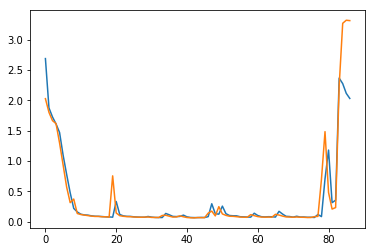

한구근 전통저그로 교유글 중시해 와쓰며 오늘라레는 성공저긴 경제적 성취에 근가느로 평까되며 경제성장에 원동녀그로 인정받꼬 읻따.<eos>                                                                                                                                          
한 ᅡ 은 앙 아으 이 ᅳ 앙ᅳ 은 아 아 ᅡ 아ᄋ은ᅧᆫ 아 ᅳᆫ ᅳᆫ ᅳ ᄋᆫ 안으 앙은 앙아 ᅥᆫᄋ앙아은안 ᄋᆫ ᅳᆫᅳ 안아 ᅡ연 ᅡᄋ아 ᅥᆼ안이 안 ᅡ 안은ᅳ 아 엉앙아 아 아ᄋ<eos>ᄋᄋᄋᄋᄋᄋᄋ아이ᄋ아ᄋᄋᄋᄋᄋᄋᄋᄋᄋ아이 ᄋᄋᄋ안ᄋᄋᄋ아ᄋ아ᄋ아ᄋᄋᄋᄋ아이 아이ᄋᄋᄋ아ᄋᄋᄋᄋᄋᄋᄋᄋᄋᄋᄋᄋᄋᄋᄋᄋᄋᄋᄋ아.ᄋᄋ이ᄋᄋᄋᄋᄋᄋᄋᄋ아ᄋᄋᄋᄋᄋ아.ᄋᄋᄋᄋᄋᄋᄋᄋᄋᄋᄋᄋᄋᄋ아.ᄋᄋᄋᄋᄋ아.ᄋ아ᄋ
한국은 전통적으로 교육을 중시해 왔으며, 오늘날에는 성공적인 경제적 성취의 근간으로 평가되며 경제성장의 원동력으로 인정받고 있다.<eos>                                                                                                                                        
쥐부레 본디 뜨슨 들쮜나 해충을 제거하기 위해 논뚝꽈 받뚜게 논는 부를 의미하지만 동시ᄋ

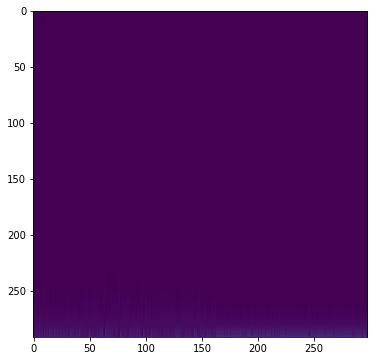

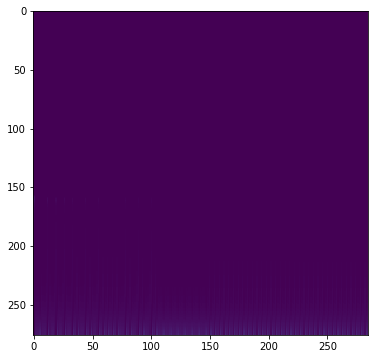

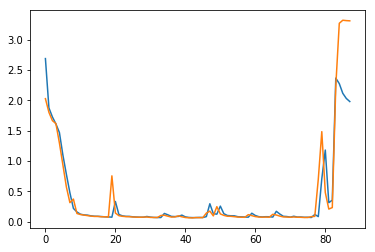

정책토론방에 토론 주제는 분기별로 각 뿌서에서 제출하거나 혀난 괄련한 거슬 모아 주민관심도 홍보 피료썽 등을 고려해 선정한다.<eos>                                                                                                                                              
잔자 아 ᄋᆼ 자은앙ᅳ  간  ᅳᆫ 간 ᅡᆼ이 ᅳᆫ앙ᄋ간 ᆫᅳ ᅥᆼ이 ᅡ 안ᅩᆼᅳᆫ안 ᅳᆼᄋ앙안 ᅡᆫ 앙 ᅳᆫ 여 안ᅵ ᅡ 아ᄋ ᄋ 안 아 앙아  ᅳ.ᅡᆼᄋ앙인 아 ᄋᆫᅡᆫ앙 ᅥᆼ안 ᅡ <eos>ᄋᄋᄋᄋᄋᄋᄋᄋᄋᄋᄋ아ᄉᄋᄋᄋ안ᄋᄋ안ᄋᄋᄋᄋᄋᄋᄋᄋᄋᄋᄋᄋ아ᄉᄋᄋᄋᄋ아사ᄋᄋᄋ안ᄋᄋ아ᄉᄋᄋᄋ아ᄉᄋᄋᄋᄋ아ᄉ아사ᄋ있ᄋᄋᄋᄋᄋᄋ아ᄋᄋᄋ있ᄋᄋ아있ᄋᄋᄋᄋᄋᄋᄋᄋᄋ아.<eos>아이ᄉᄋᄋᄋᄋᄋᄋᄋ안ᄋ이ᄋ아ᄋᄋᄋᄋᄋᄋ안ᄋ
정책토론방의 토론 주제는 분기별로 각 부서에서 제출하거나 현안 관련한 것을 모아 주민관심도, 홍보 필요성 등을 고려해 선정한다.<eos>                                                                                                                                                 
창신 학꾜를 공통분모로 하여 일제강점기 민족쭈이 저항 활똥에 나선 이드를 연겨

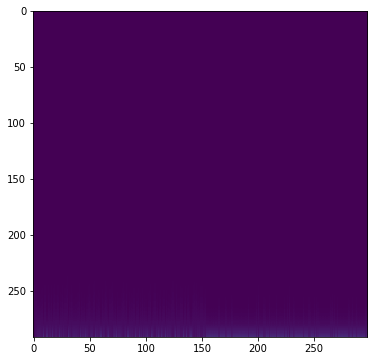

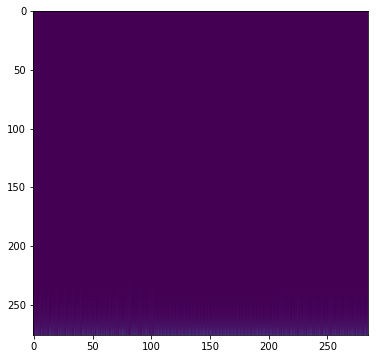

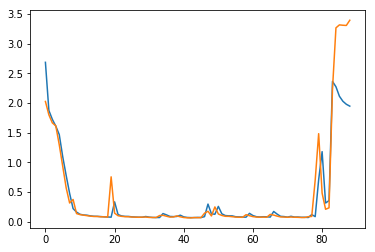

구청장은 정보화를 추진하는 경우 지여게 수요와 특썽을 고려하여야 하며 관계 기과네 의겨늘 수렴하고 그 결과를 최대한 바녕하여야 한다.<eos>                                                                                                                                             
그 ᅥᆫ이 인 강앙ᅡᆫᅳᆫ 인ᅥᆼ안ᅳᆫ 앙으 아 ᅳᆫ으 안 ᆼᅳ 안 ᅡᆼ은 아 ᅳᆫᅡᆫᅳ 아간ᅧᆫ 이ᄋ아ᄋ아 ᅡ 으 이 ᅩ 은 안ᅳᆫ안ᅩ 알앙 ᅡ ᅳᆫ 아아 ᅡᆫ 안 ᅳᆫ ᅡᆫᅭ ᅭ.안 ᅡ <eos>ᄋ아ᄉᄋᄋᄋᄋᄋᄋᄋᄋᄋ이ᄉᄋᄋᄋ이ᄉᄋᄋ아가ᄒᄋᄋᄋ아ᄉᄋᄋᄋᄋᄋᄋ아ᄋᄋᄋᄋᄋᄋᄋᄋ이ᄉᄋᄋᄋᄋᄋᄋᄋᄋᄋᄋᄋᄋᄋᄋᄋ이 ᄋᄋᄋᄋ안이ᄉᄋᄋᄋᄋᄋᄋ이ᄋᄋᄋᄋᄋᄋᄋ이ᄉᄋᄋᄋᄋᄋ이ᄋᄋᄋᄋ이ᄋ아ᄋ이ᄉᄋᄋ안ᄋ있ᄋᄋᄋᄋᄋᄋᄋᄋ이ᄋᄋᄋᄋ
구청장은 정보화를 추진하는 경우 지역의 수요와 특성을 고려하여야 하며, 관계 기관의 의견을 수렴하고 그 결과를 최대한 반영하여야 한다.<eos>                                                                                                                                               
그러나 한구긴드리 항상 외부 세계와 교류해왇꼬 다양한 시기에 외구기늘 자시네 구성워느로 바

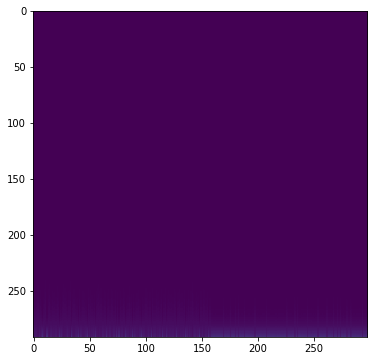

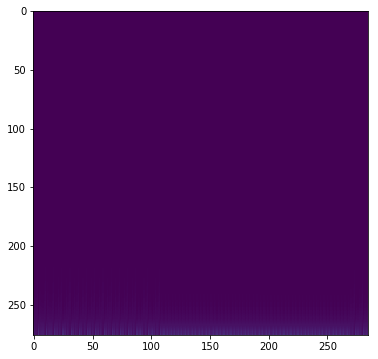

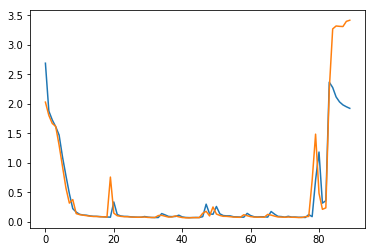

위워는 체유캥정에 관한 학씩꽈 경허미 읻꼬 지역싸회 체육찐흥을 위하여 헌신저그로 활똥할 쑤 인는 사람 중에서 구청장이 위초칸다.<eos>                                                                                                                                           
위 ᅳᆫ ᅳᆫ 가 ᅳ 으 앙으 앙 ᅡᆫ 간 ᅥ 으 앙안으 이 아 아 ᅳᆫ언ᅡᄋ이 이 ᄋ 안이  이 ᅡᆫᅭ.안 ᅥ 엉은 이ᅡᄋ ᄋ 안 안으 안 이 ᅳ 은 으 ᅥ 이 ᄋᆫ언이 아어 은 ᅡ <eos>으ᄋ아ᄉᄋᄋ이ᄉ이ᄉᄋ이이ᄉᄋ이ᄉ아ᄉᄋ아ᄉᄋᄋᄋᄋ이ᄋᄋᄋ아이ᄉᄋᄋ아ᄉᄋ있ᄋᄋᄋᄋᄋᄋᄋᄋᄋᄋᄋᄋ이사ᄋᄋ아있ᄋᄋᄋᄋ아ᄉ아아.ᄋᄋ이ᄋᄋᄋᄋᄋᄋᄋᄋᄋᄋᄋᄋᄋᄋᄋᄋᄋᄋᄋ이ᄉᄋᄋᄋᄋᄋᄋᄋᄋᄋ이ᄋᄋᄋᄋᄋ안ᄋᄋᄋᄋᄋ아
위원은 체육행정에 관한 학식과 경험이 있고 지역사회 체육진흥을 위하여 헌신적으로 활동할 수 있는 사람 중에서 구청장이 위촉한다.<eos>                                                                                                                                             
즉 배출량이나 대기에 화학쩍 조성이 장년과 비해 크게 변하지 아낟따면 바라미나 온도분포

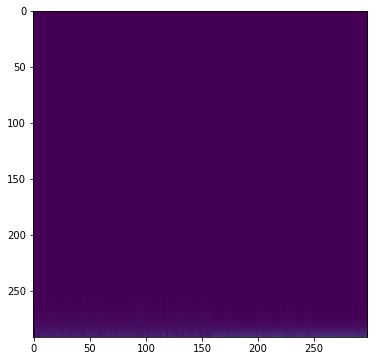

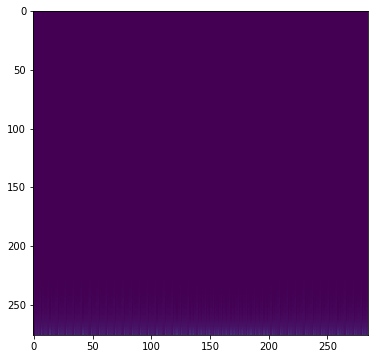

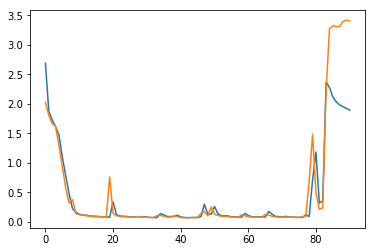

전날 보고서는 이익 추정치를 조금 더 보수저그로 추정하기 위한 거실 뿐 여녜기획싸 시장에 전망을 부정저그로 본 게 전혀 아니라는 취지다.<eos>                                                                                                                                          
정장인 아ᅡᆼᅳᆫ 가 ᅳ 안 ᅥᆼ으 ᅳᆫ 앙ᅩ ᄋ강앙ᄋ ᅥᆼ은  안ᅥᆼ안ᅩ 아 ᅡᆫ 강 ᅳ  안 앙 이ᅡ ᅡᆫ엉아 ᄋᆫ으 앙 ᅧᆫ인 안ᅥᆼ앙일ᅩ 앙ᄋ아 앙안안ᅳᆫ 안 앙ᅵ ᅡ <eos> ᄋ아ᄉᄋᄋᄋᄋ아ᄉᄋᄋᄋ아ᄉᄋᄋᄋᄋ아ᄉᄋᄋᄋ안ᄋ아ᄋᄋᄋ아ᄉᄋᄋᄋᄋᄋᄋᄋ아ᄉᄋᄋᄋᄋᄋᄋᄋᄋ안ᄋ아ᄉᄋ아ᄉᄋᄋᄋᄋ아ᄉᄋᄋ안ᄋᄋᄋᄋᄋᄋᄋ아ᄉᄋᄋᄋᄋ아사가ᄒᄋᄋᄋᄋᄋ아ᄉᄋᄋᄋᄋ안ᄋᄋᄋ아.<eos>ᄋᄋ아사ᄀᄋᄋᄋᄋᄋᄋᄋᄋᄋᄋ
전날 보고서는 이익 추정치를 조금 더 보수적으로 추정하기 위한 것일 뿐 연예기획사 시장의 전망을 부정적으로 본 게 전혀 아니라는 취지다.<eos>                                                                                                                                             
한국 고교축꾸는 소쑤 정예 엘리트 육썽에 집쭝하고 읻찌만 아이러니하게도 고교 축꾸ᄋ

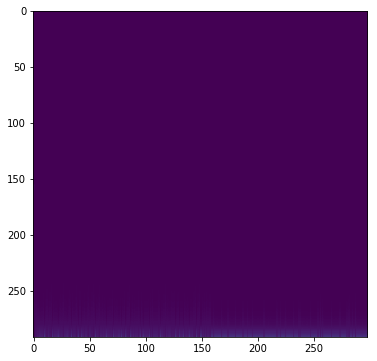

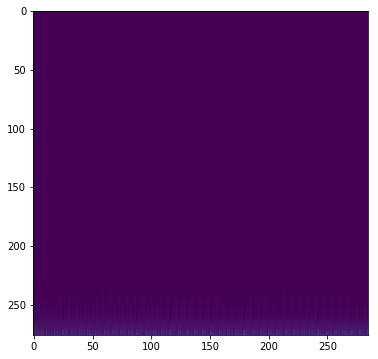

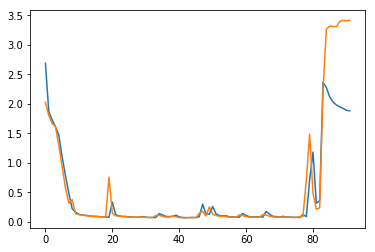

수믄 태그 애플리케이셔는 보안 라베레 사빕뙤 남호화 데이터를 화긴할 쑤 인는 유일한 방버브로 정푸민증에 보안성을 상승시켣따.<eos>                                                                                                                                                 
산ᄋᆫ ᅡ ᅩᆫ잉ᅡᆫ ᅩ ᅡ ᅳ ᅥᆫ ᅳᆫ 강ᅳᆫ 공ᅡ 으 앙으 아ᄋ 긴앙ᄋ 아은ᅡᆼᄋᆫ 안으 안 인으 은 이으 안 강앙이 ᅳ 앙안으 얼이 잉ᅭᆫ ᅡᆼ일 앙일 앙ᄋ앙<eos>으ᄒ안ᄋᄋᄋᄋᄋ이사가ᄒᄋᄋ안ᄋᄋᄋ안이ᄉᄋᄋᄋᄋᄋ안 ᄋᄋᄋ안 ᄋ아사ᄉᄋᄋᄋ아ᄉᄋ안 ᄋᄋᄋᄋᄋᄋᄋ안ᄋᄋᄋᄋ아ᄉᄋᄋᄋᄋᄋᄋ안ᄋᄋᄋᄋᄋᄋᄋᄋᄋᄋᄋᄋᄋ아ᄋᄋᄋ안 ᄋᄋᄋ아ᄒᄋᄋᄋ아ᄋ안 ᄋ아ᄋᄋᄋ아ᄋ아아ᄋᄋᄋᄋ
히든태그 애플리케이션은 보안 라벨에 삽입된 암호화 데이터를 확인할 수 있는 유일한 방법으로 정품인증의 보안성을 상승시켰다.<eos>                                                                                                                                                  
과낙꾸 대책뽄부장은 재난현장에 출똥한 재난괄리채김기과니 쉽께 접끈할 쑤 인느 나

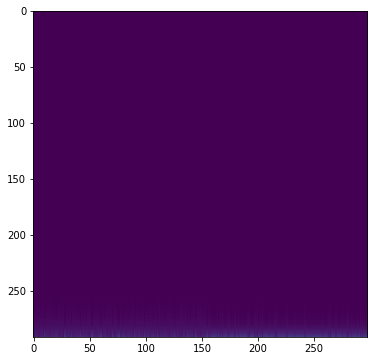

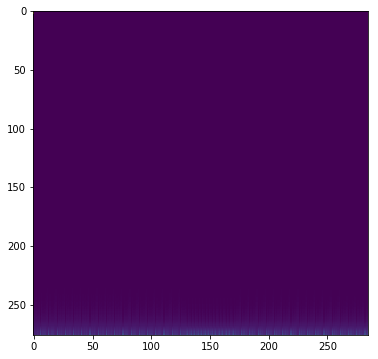

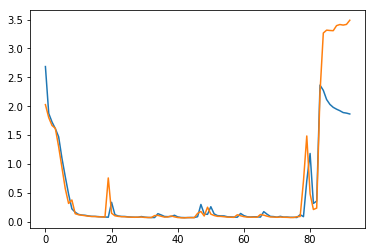

호남대 토벌작쩌는 조서네 동니블 위해 투쟁하 늬병드를 말쌀시키기 위한 작쩌느로 호남 의병에 세려기 잠시 주춤하는 계기가 되얻따.<eos>                                                                                                                                                  
학ᄋᆫ ᅡ 이ᅡᆼ ᅡᆼ언은 강ᄋ  ᄀ 앙오 은 가아 아 ᅥᆼ안 가 ᄋᆫ은 ᅳᆫ 강 ᅡᆫ ᅡ ᅡ ᅡ 아안 강언을ᅩ 앙ᅳᆫᄋ이 ᅡᆫ으 아 ᅩ 으 인 ᅥ 악ᅥᆼ안ᅳᆫ 가오 ᅩ 이요 안  ᄋᄋ아ᄀᄋᄋᄋᄋ이가ᄀᄋᄋ안ᄋᄋᄋᄋᄋ안ᄋᄋᄋᄋᄋ아ᄀᄋᄋᄋᄋᄋᄋᄋᄋᄋᄋ아ᄋ아ᄋᄋᄋ안아ᄀᄋ아ᄋᄋᄋ안ᄋᄋᄋᄋᄋᄋᄋ아가ᄋᄋᄋᄋᄋᄋᄋᄋᄋ안 ᄋᄋᄋᄋ아ᄀᄋᄋᄋ아ᄋᄋᄋᄋᄋᄋᄋᄋ아아ᄀᄋ아ᄋᄋᄋ아ᄋᄋ아아ᄀᄋ안ᄋᄋᄋᄋᄋᄋᄋ아ᄀ
호남대토벌작전은 조선의 독립을 위해 투쟁한 의병들을 말살시키기 위한 작전으로 호남 의병의 세력이 잠시 주춤하는 계기가 되었다.<eos>                                                                                                                                                   
구청장은 지도점검 결과 민가뉘탁싸무에 처리가 위법 뿌당하거나 혀뱌글 위반한 때에는 수탁ᄁ

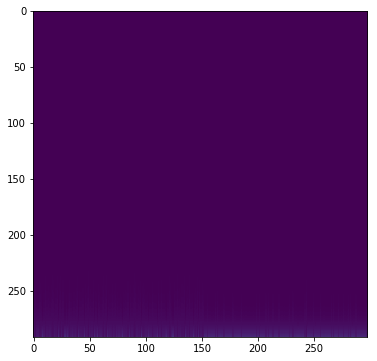

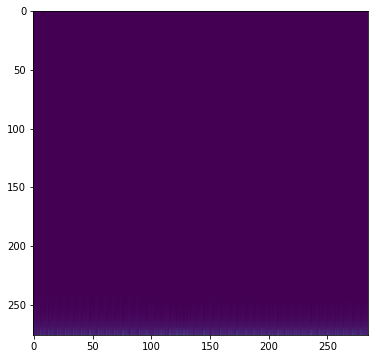

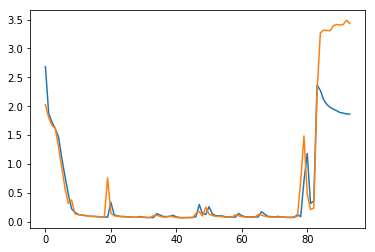

정월 대보름과 이월 초하룬날쯔믄 한해가 시자칸 지 얼마 안 된 시기로 정갈하게 한 해를 시자카고자 냄새나는 노래기부터 업쌔고자 한 거시다.<eos>                                                                                                                                        
정인 강은  ᅡ 인ᅴᆫ 강ᅡᆫᅳ 은 ᅡᆫ ᅳᆫ 간 가ᅡ 앙ᅥᆼ안 가 앙 ᅧᆫ안 가ᄋ 가 ᅡ ᄋ 아ᅥᆼ아  ᅡᆫ  안 강ᅩᆯ 아 ᄋᆫ안ᅩ ᅥᆼ아요ᅥᆼᅳᆫᅳᆫ 강ᅩ ᄋ ᅮ ᅡᆼ앖으 ᅩ ᅥᆼ안 강으 ᅡ <eos> 안ᄋ아ᄀᄋᄋᄋᄋᄋᄋ아하ᄀᄋᄋᄋᄋᄋᄋ아ᄀᄋᄋᄋᄋᄋᄋᄋᄋᄋᄋᄋᄋᄋᄋᄋᄋᄋᄋᄋᄋ아ᄀᄋᄋᄋᄋᄋᄋ아ᄀᄋᄋᄋᄋᄋ아ᄀᄋᄋ안ᄋ가ᄒᄋᄋᄋᄋᄋ아한ᄋ안ᄋᄋ아ᄋᄋᄋᄋ아가ᄒ아가하ᄀᄋᄋᄋᄋᄋᄋᄋᄋᄋᄋᄋᄋᄋᄋᄋᄋᄋᄋᄋᄋ아.<eos>ᄋᄋᄋ
정월 대보름과 이월 초하룻날쯤은 한해가 시작한 지 얼마 안 된 시기로, 정갈하게 한 해를 시작하고자 냄새나는 노래기부터 없애고자 한 것이다.<eos>                                                                                                                                          
압써 우즈는 대회 첟째 날과 둘째 날 열린 두 차례 포볼 경기 그리고 섿째 날 열린 포

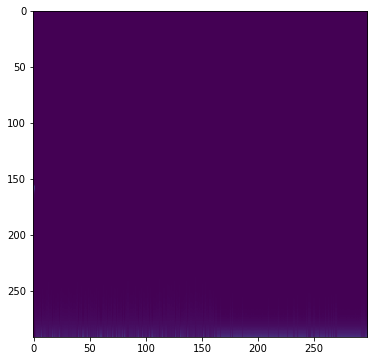

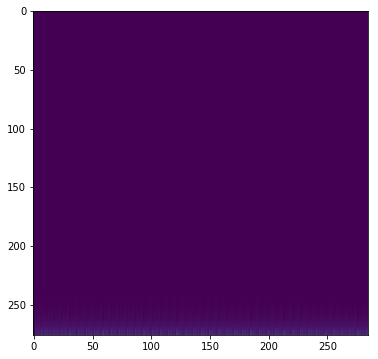

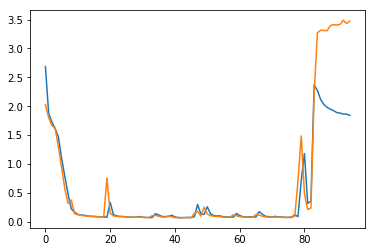

민간환경단체 등 구민단체는 구미네 환경보전 실처니지를 노피기 위한 홍보와 환경오염 감시 등에 환경보전활똥에 노려카여야 한다.<eos>                                                                                                                                            
뭋앙 ᅡᆫ ᅡᆼ앙 ᅡ 인ᄋ강은ᅡ  ᅡ ᅳᆫ 강ᅮᆫ으 안 ᅡ 옹ᅵᆼᄋ가 앙으 ᅥ ᅳᆯ 앙으 ᅩ 인ᅡᆫ 강이 ᅳ 안앙이 ᄋᆫᄋ앙이 일 ᅳ 안을옹ᅵ 안으 아 있ᄋᆫ안 ᆫᅳ 한 ᅡ <eos>ᄋᄋᄋᄋ이ᄒᄋᄋ이한ᄋ이ᄒᄋᄋ아ᄒᄋᄋᄋ이ᄒ이ᄒᄋᄋᄋᄋᄋᄋᄋᄋ있이ᄒᄋᄋᄋ있ᄋ아ᄒ이ᄒᄋᄋ이ᄋᄋ이ᄒᄋᄋᄋᄋᄋᄋᄋ이하ᄒ이ᄒᄋᄋᄋᄋᄋᄋᄋ이ᄒ이하ᄒᄋᄋᄋᄋ이ᄒ아ᄒᄋᄋᄋᄋᄋᄋᄋᄋᄋ이ᄋᄋᄋᄋ아ᄒᄋᄋᄋᄋᄋᄋᄋᄋ있이ᄒᄋ이
민간환경단체 등 구민단체는 구민의 환경보전 실천의지를 높이기 위한 홍보와 환경오염 감시 등의 환경보전활동에 노력하여야 한다.<eos>                                                                                                                                               
축쩨는 개인 또는 공동체에 특뼐하 늬미가 읻꺼나 결쏭녀글 주는 사꺼니나 시기를 기념하

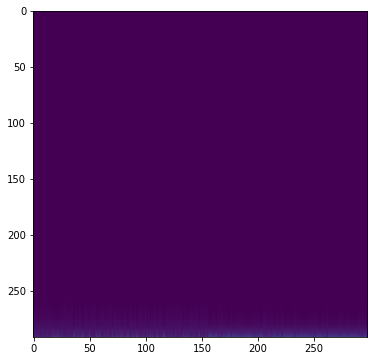

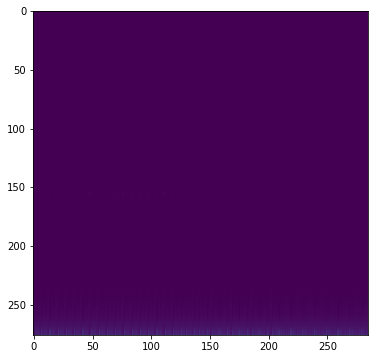

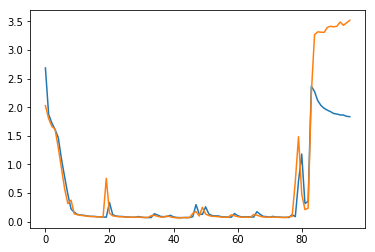

그 바께 노리시설 쩐수실태 조사 안전괄리자 현장 년쑤 등 어리니노리시서레 안전썽 확뽀 믿 효율쩌긴 뉴지괄리를 위하여 피료한 사항항<eos>                                                                                                                                             
그ᄅ장으 은 ᅳᆫᅥ ᅥ  궁으 ᅥ  ᄀ 웅ᅥᆼ 긴잉아 은ᅵᆼ안 ᅥᆼᄋ깅이 알ᄋ잉ᅳ 으 ᅳ  ᅳ ᅥ ᅥ  ᅳ 인 ᅥᆼ앙ᄋ간옹앛으ᅡ효  ᅵᆼ이 ᄋ기어 ᅩ 아 ᅳᆯ 이안ᅭᆫ있으.ᅡᆫ 강ᅡᆫᄋ ᄋᄋᄋ이ᄒᄋᄋᄋ이ᄒᄋᄋᄋ있이ᄉᄋᄋᄋᄋ이ᄒᄋᄋᄋᄋᄋᄋᄋᄋᄋᄋᄋᄋ이ᄒ아하ᄋᄋ이서하ᄀᄋ이ᄒᄋ이ᄒᄋᄋᄋ있ᄋᄋᄋᄋᄋ아한ᄋᄋᄋᄋᄋᄋᄋᄋᄋ있이ᄋᄋᄋ아.ᄋᄋᄋᄋ이ᄒᄋᄋᄋᄋᄋᄋᄋᄋᄋ아아.ᄋᄋᄋ아ᄒᄋᄋᄋᄋᄋ이이ᄒᄋᄋᄋ아
그 밖에 놀이시설 전수실태 조사, 안전관리자 현장 연수 등 어린이놀이시설의 안전성 확보 및 효율적인 유지관리를 위하여 필요한 사항<eos>                                                                                                                                               
가튼 뉴신체제에서 대서늘 치르려는 전두환 대통녕에 계회근 야당 지도자드를 격뿐시켣꼬 재야

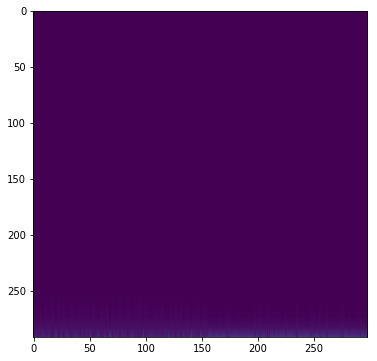

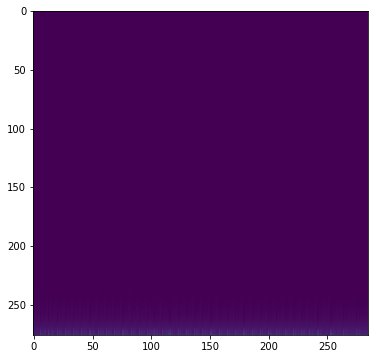

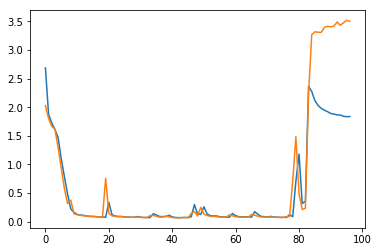

신부 쪼게는 소늘 씯꼬 다끌 쑤 읻또록 무리 담긴 대야와 술주전자를 두고 실랑 쪼게는 특뼐히 지베서 만든 두부와 저까라글 놔둔다.<eos>                                                                                                                                                 
성온은 ᄀ ᄋᆫ 강은 아ᄋ아 앙은 강으 으 ᅳ ᄋ간 ᅳ 앙아 ᄋ가을ᅳ 앙이 ᅥᆼ엉ᅩᆯ 아오  가 옹이  으 ᅳᆫ 강옹 ᅡ 있으 ᅥ 안 ᅡᆯ 아 ᅡᆫᅭ 잉아 ᅳ 을 안ᅡ 아 <eos> ᄋᄋᄋ있ᄋᄋᄋᄋ이ᄒᄋᄋᄋᄋᄋᄋᄋᄋᄋᄋᄋ이ᄋᄋᄋᄋᄋᄋ있ᄋᄋᄋᄋᄋᄋᄋᄋ이ᄋᄋᄋᄋᄋᄋᄋᄋᄋᄋᄋᄋᄋᄋ아ᄋᄋᄋᄋᄋᄋ이ᄋ이ᄋᄋᄋᄋᄋᄋᄋᄋᄋᄋᄋᄋ이ᄋᄋᄋᄋ이ᄋ이ᄋᄋᄋᄋᄋᄋᄋᄋᄋᄋᄋᄋ있ᄋᄋᄋᄋ이안ᄋᄋᄋ이ᄋᄋᄋᄋᄋᄋᄋᄋᄋᄋᄋᄋᄋ이안
신부 쪽에는 손을 씻고 닦을 수 있도록 물이 담긴 대야와 술주전자를 두고, 신랑 쪽에는 특별히 집에서 만든 두부와 젓가락을 놔둔다.<eos>                                                                                                                                               
납폐가 끈나고 나면 곧 홀례시글 거행하게 되는데 신부 집 암마당에 천마글 치고 휘장을

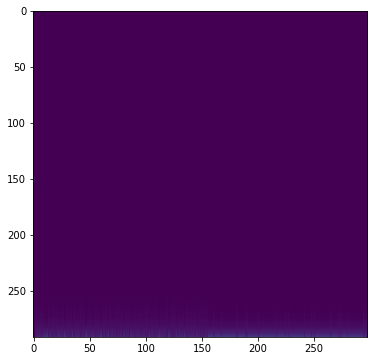

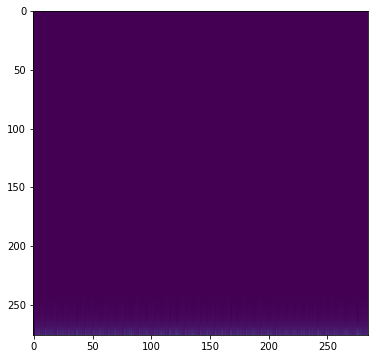

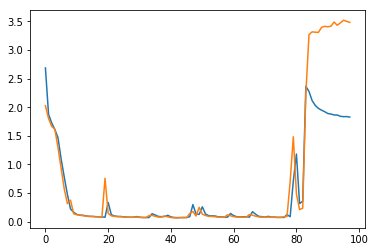

구청장은 청소년 중시메 교육쩡보 제공 믿 지원 등 설치목쩌게 저카파게 우녕해야 하며 시설리용자에게 공정하 니용기회를 부여해야 한다.<eos>                                                                                                                                           
그릉익은 중잉ᅳᆫ 궁인으 앙ᅳᆫ ᅥᆼ으 우오 ᄋ군으ᅵ ᅳᆫ 강ᄋ궁이 ᅧ 웅으 웅안 ᅡᆫᅩ 일은안  한 ᆫ 안ᄋ  ᅳ ᄋ 훙ᅵ ᅩ 잉이 인 가을으 ᄋ올 옹ᅥᆫᅡ요 한 ᅡᄋ<eos> ᄋᄋ이ᄒᄋᄋ이ᄒ있ᄋᄋᄋᄋ이ᄒᄋᄋᄋᄋᄋᄋᄋᄋᄋᄋᄋ이ᄒᄋᄋᄋᄋᄋᄋ이ᄒᄋᄋᄋᄋᄋᄋᄋ있이ᄒ이ᄒ이ᄒᄋᄋᄋᄋ이하ᄀᄋ이ᄒ있ᄋ있ᄋᄋᄋᄋᄋᄋᄋᄋ이ᄒ이ᄒᄋᄋ이ᄒ이하ᄀ이ᄒᄋ이하ᄋᄋ이ᄒᄋᄋᄋᄋᄋᄋ이ᄒᄋᄋ이한ᄋᄋᄋ
구청장은 청소년 중심의 교육정보 제공 및 지원 등 설치목적에 적합하게 운영해야 하며, 시설이용자에게 공정한 이용기회를 부여해야 한다.<eos>                                                                                                                                           
무관세로 드러온 서양에 물건드른 조서네 수공업짜 소장농민 중소상이네 재정파타늘 초래

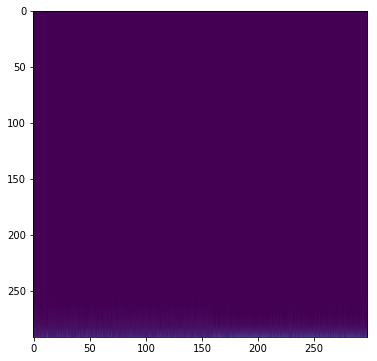

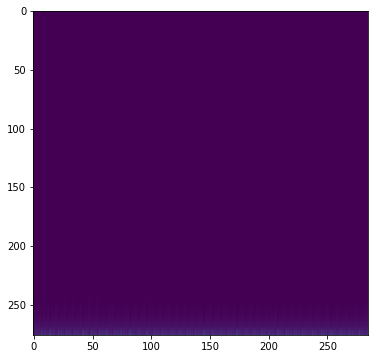

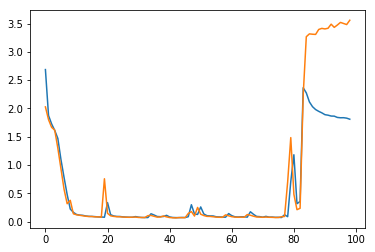

구청장은 아동학때 예방과 방지를 위한 목쩌그로 활똥하는 단체 또는 시서레 대하여 피료한 사업삐를 예사네 버뮈에서 지원할 쑤 읻따.<eos>                                                                                                                                               
그 ᅥᆼ잉은 강ᅡ 안 ᅡ 이성오 인이 ᅳᆯ 기산 가 잉을 ᄀ간 ᄀ 안ᅳᆫ 강 ᅡ 앙ᅳᆫ 구 ᅥ  ᅳ 아안ᅭ.<eos>ᅥ  ᅳ.ᅡᆫ 강ᅳ 오 ᅳᆯ 깄ᅥ  ᅳ 옹으 ᅭ.ᅵ 있ᅭᆫ ᄀᆫ 가 있으 <eos> ᄋᄀᄋᄀᄀᄋᄀᄋᄋᄀ이ᄀ이강ᄋᄀᄋᄋᄋᄋᄋᄋᄀᄋᄋᄋᄀᄋᄋᄋ이ᄀᄋ이ᄀᄋᄋ이ᄀᄋᄋᄋᄋ있ᄋᄋᄋᄋᄋᄋᄋᄋᄋ있ᄋᄋᄋᄋᄋᄋᄀᄋ있ᄋᄋ있ᄋᄋᄋ이있ᄋᄋᄋᄋᄋᄋ이ᄀᄋ이ᄀᄋ있ᄋ이ᄀ있ᄋᄋᄋ이ᄀᄋᄋᄋᄋ이ᄀᄋᄋ이ᄀᄋᄋ이ᄋ있ᄋᄋᄋᄋᄋ
구청장은 아동학대 예방과 방지를 위한 목적으로 활동하는 단체 또는 시설에 대하여 필요한 사업비를 예산의 범위에서 지원할 수 있다.<eos>                                                                                                                                                 
조선 시대 봉수대에 원형 구조는 정화키 알 쑤 업쓰나 봉수대에 시설물과 함께 당나무ᄅ

In [0]:
# 'keyword' determines the save keyword
# Change this keyword if you want to start training a new model
keyword = 'eumun-to-eumjul-bidirectional-2'

# List of loss values
loss_history_train = list()
loss_history_eval = list()

try:
    loss_history_train = np.load('gdrive/My Drive/korean-single-speaker-speech-dataset/kss/model_saved/loss_history_train_{}.npy'.format(keyword)).tolist()
    loss_history_eval = np.load('gdrive/My Drive/korean-single-speaker-speech-dataset/kss/model_saved/loss_history_eval_{}.npy'.format(keyword)).tolist()
except:
    print("Loading Failed")

EPOCH = 3 * 60 * 4
    
# Load model if model weights already exists
try:
    net.load('gdrive/My Drive/korean-single-speaker-speech-dataset/kss/model_saved/{}'.format(keyword))
except:
    print("Loading Error")
    
for epoch in range(EPOCH):
    
    print(datetime.now().strftime('%m-%d %H:%M:%S'))
    
    net.set_mode('train')
    train_batch_loader.initialize_batch()
    loss_list_train = list()
    
    while train_batch_loader.end_flag == False:
        eumjul_batch, eumun_batch, eumun_loss_mask = train_batch_loader.get_batch()
        pred_tensor, attention_tensor, loss = net.train(eumun_batch.to(device), eumjul_batch.to(device), eumun_loss_mask.to(device))        
        loss_list_train.append(loss)

    print(datetime.now().strftime('%m-%d %H:%M:%S'))
    print("Mean Train Loss: {}".format(np.mean(np.asarray(loss_list_train))))
    loss_history_train.append(np.mean(np.asarray(loss_list_train)))
    
    net.set_mode('eval')
    eval_batch_loader.initialize_batch()
    loss_list_eval = list()
    
    while eval_batch_loader.end_flag == False:
        eumjul_batch_, eumun_batch_, eumun_loss_mask = eval_batch_loader.get_batch()
        pred_tensor_, attention_tensor_, loss = net.evaluate(eumun_batch_.to(device), eumjul_batch_.to(device), eumun_loss_mask.to(device))        
        loss_list_eval.append(loss)

    print(datetime.now().strftime('%m-%d %H:%M:%S'))
    print("Mean Evaluation Loss: {}".format(np.mean(np.asarray(loss_list_eval))))
    loss_history_eval.append(np.mean(np.asarray(loss_list_eval)))
    
    plt.figure()
    plt.plot(loss_history_train)
    plt.plot(loss_history_eval)
    plt.show()
    
    sentence = tokenizer.num2word(eumun_batch[0].detach().cpu().numpy().astype(int))
    print(''.join(sentence))

    _, pred_token = pred_tensor[0].max(-1)
    sentence = tokenizer.num2word(pred_token.detach())
    print(''.join(sentence))
    
    sentence = tokenizer.num2word(eumjul_batch[0].detach().cpu().numpy().astype(int))
    print(''.join(sentence))

    plt.figure(figsize = (6, 6))
    plt.imshow(attention_tensor[0].detach().cpu().numpy())
    plt.show
    
    sentence = tokenizer.num2word(eumun_batch_[0].detach().cpu().numpy().astype(int))
    print(''.join(sentence))

    _, pred_token = pred_tensor_[0].max(-1)
    sentence = tokenizer.num2word(pred_token.detach())
    print(''.join(sentence))
    
    sentence = tokenizer.num2word(eumjul_batch_[0].detach().cpu().numpy().astype(int))
    print(''.join(sentence))

    plt.figure(figsize = (6, 6))
    plt.imshow(attention_tensor_[0].detach().cpu().numpy())
    plt.show

    net.save('gdrive/My Drive/korean-single-speaker-speech-dataset/kss/model_saved/{}'.format(keyword))
    np.save('gdrive/My Drive/korean-single-speaker-speech-dataset/kss/model_saved/loss_history_train_{}.npy'.format(keyword), loss_history_train)
    np.save('gdrive/My Drive/korean-single-speaker-speech-dataset/kss/model_saved/loss_history_eval_{}.npy'.format(keyword), loss_history_eval)
    

    print("-------------------------------------------------------------------------------------------------------")